![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Research to Production
## Mean Reversion
---------
### Introduction
Imagine that we've developed the following hypothesis: stocks that are below 1 standard deviation of their 30 day mean are due to revert and increase in value, statistically around 85% chance if we assume the return series is stationary and the price series is a Random Process. We've developed the following code in research to pick out such stocks from a preselected basket of stocks.

<a href="https://www.quantconnect.com/docs/v2/research-environment/tutorials/research-to-production/mean-reversion">Documentation</a>

### Import Libraries
We'll need to import packages to help with data processing. Import numpy and scipy packages by the following:

In [1]:
import numpy as np
from scipy.stats import norm, zscore

### Gathering Data
To begin, we retrieve historical data for research.

In [2]:
# Instantiate a QuantBook.
qb = QuantBook()

# Select the desired tickers for research.
symbols = {}
assets = ["SHY", "TLT", "SHV", "TLH", "EDV", "BIL",
          "SPTL", "TBT", "TMF", "TMV", "TBF", "VGSH", "VGIT",
          "VGLT", "SCHO", "SCHR", "SPTS", "GOVT"]

# Call the AddEquity method with the tickers, and its corresponding resolution. Then store their Symbols. Resolution.Minute is used by default. 
for i in range(len(assets)):
    symbols[assets[i]] = qb.AddEquity(assets[i],Resolution.Minute).Symbol

# Call the History method with qb.Securities.Keys for all tickers, time argument(s), and resolution to request historical data for the symbol.
history = qb.History(qb.Securities.Keys, datetime(2020, 1, 1), datetime(2022, 1, 1), Resolution.Daily)
history

close       high        low       open  \
symbol           time                                                     
TLO TT1EBZ21QWKL 2020-01-03  38.039464  38.155467  37.937961  37.981462   
                 2020-01-04  38.600147  38.609814  38.276304  38.348807   
                 2020-01-07  38.387474  38.755399  38.377807  38.735485   
                 2020-01-08  38.223136  38.426142  38.203802  38.368140   
                 2020-01-09  37.962128  38.388828  37.855792  38.300472   
...                                ...        ...        ...        ...   
BIL TT1EBZ21QWKL 2021-12-28  91.430000  91.430000  91.420000  91.420000   
                 2021-12-29  91.420000  91.430000  91.420000  91.430000   
                 2021-12-30  91.420000  91.430000  91.420000  91.420000   
                 2021-12-31  91.430000  91.430000  91.390000  91.420000   
                 2022-01-01  91.430000  91.430000  91.420000  91.420000   

                                volume  
symbol           time                   
TLO TT1EBZ21QWKL 2020-01-03  1576493.0  
                 2020-01-04   955604.0  
                 2020-01-07  1070539.0  
                 2020-01-08   358823.0  
                 2020-01-09   656110.0  
...                                ...  
BIL TT1EBZ21QWKL 2021-12-28   729055.0  
                 2021-12-29  1932904.0  
                 2021-12-30  1244000.0  
                 2021-12-31   833112.0  
                 2022-01-01   868470.0  

[9090 rows x 5 columns]

### Preparing Data
We'll have to process our data to get an extent of the signal on how much the stock is deviated from its norm for each ticker. Since we're assuming Randon Process for the price series, and we can obtain the expected return and probability, we can use kelly criterion for portfolio allocation. To do so, please refer to <a href="https://www.academia.edu/1027427/Algorithms_for_optimal_allocation_of_bets_on_many_simultaneous_events">Algorithms for optimal allocation of bets on many simultaneous events - C. Whitrow (2007)</a>.

In [3]:
# Select the close column and then call the unstack method.
df = history['close'].unstack(level=0)

# Calculate the truth value of the most recent price being less than 1 standard deviation away from the mean price.
classifier = df.le(df.rolling(30).mean() - df.rolling(30).std())

# Get the z-score for the True values, then compute the expected return and probability (used for Insight magnitude and confidence).
z_score = df.apply(zscore)[classifier]
magnitude = -z_score * df.rolling(30).std() / df
confidence = (-z_score).apply(norm.cdf)

# Call fillna to fill NaNs with 0
magnitude.fillna(0, inplace=True)
confidence.fillna(0, inplace=True)

# Get our trading weight, we'd take a long only portfolio and normalized to total weight = 1
weight = confidence - 1 / (magnitude + 1)
weight = weight[weight > 0].fillna(0)
sum_ = np.sum(weight, axis=1)
for i in range(weight.shape[0]):
    if sum_[i] > 0:
        weight.iloc[i] = weight.iloc[i] / sum_[i]
    else:
        weight.iloc[i] = 0
weight = weight.iloc[:-1]

/opt/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


### Test the Hypothesis
We would test the performance of this strategy. To do so, we would make use of the calculated weight for portfolio optimization.

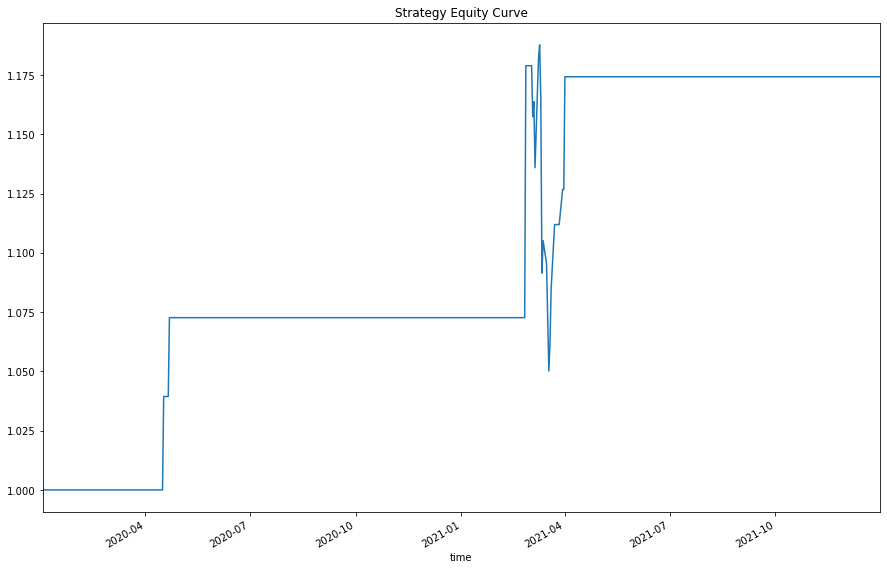

In [4]:
# Get the total daily return series
ret = pd.Series(index=range(df.shape[0] - 1))
for i in range(df.shape[0] - 1):
    ret[i] = weight.iloc[i] @ df.pct_change().iloc[i + 1].T
    
# Call cumprod to get the cumulative return
total_ret = (ret + 1).cumprod()

# Set index for visualization
total_ret.index = weight.index

# Plot the result
total_ret.plot(title='Strategy Equity Curve', figsize=(15, 10))
plt.show()